# DA 224-O Practical Machine Learning
### Tutorial on Clustering

##Learning Objectives

At the end of the experiment, you will be able to

* understand what is Unsupervised Learning
* perform Clustering (k-means, dbscan)


### Introduction

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets without human intervention, in contrast to supervised learning where labels are provided along with the data.

Unsupervised learning tasks includes Clustering,Anomaly detection and Density estimation.Here we are going to discuss about clustering.

* **Clustering:** The goal is to group similar instances together into clusters. It is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.




### Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, image
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

### K-Means 

The k-means algorithm is a simple algorithm capable of clustering very quickly and efficiently, often in just a few iterations.

A **cluster** refers to a collection of data points aggregated together because of certain similarities.

Here we need to define a target number k, which refers to the number of centroids we need in the dataset. A **centroid** is the imaginary or real location representing the center of the cluster.

Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
In other words, the k-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.

**Exercise 1: Load the Iris dataset**

In [2]:
# Load Iris dataset
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]
X = StandardScaler().fit_transform(X)

**Exercise 2: Visualize the data using petal length (cm) and petal width (cm)**




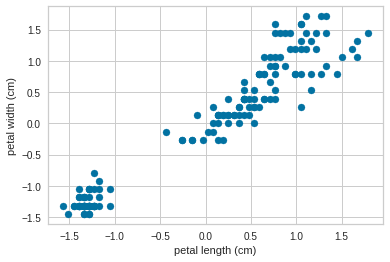

In [3]:
# Visualize the data using two features
plt.scatter(X[:,2], X[:,3])
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.show()

**Exercise 3: Perform k-means clustering**

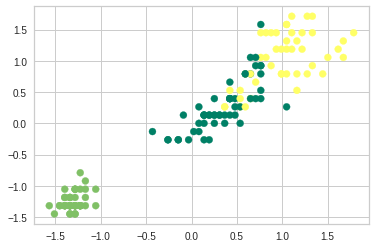

In [4]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=1)
y_predict = kmeans.fit_predict(X)
plt.scatter(X[:,2], X[:,3], c=y_predict, cmap = 'summer')
plt.show()

From the above plot, we can see that only by specifying the number of clusters k-means identifies them within the dataset.

#### Centroid initialization methods

**Exercise 4: Perform k-means clustering with specified centroids and plot the initial centroids and centroids after one iteration**


If we happen to know approximately where the centroids should be, then we can set the `init` hyperparameter to a NumPy array containing the list of centroids, and set number of iteration (`n_init`) to 1:

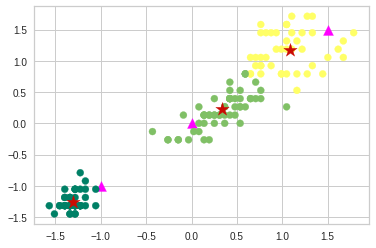

In [5]:
# Perform k-means clustering with specified centroids
good_init = np.array([[-1, -1], [0, 0], [1.5, 1.5]])
kmeans = KMeans(n_clusters = 3, init = good_init, n_init = 1,max_iter=1, random_state = 1)
# Make prediction using only two features, as centroids are specified for only two features
y_predict = kmeans.fit_predict(X[:,2:])    
     
# Plot initial centroids
plt.scatter(x = [-1, 0, 1.5], y = [-1,0, 1.5], c = 'magenta', s = 100, marker= "^")
# Plot data points
plt.scatter(X[:,2], X[:,3], c = y_predict, cmap = 'summer')
# Plot centroids after iteration
plt.scatter(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], c = 'r', marker="*", s = 200)
plt.show()

Scikit-Learn knows which solution is the best by using a performance metric called the model's **inertia**, which is the mean squared distance between each instance and its closest centroid. The `KMeans` class runs the algorithm `n_init` times and keeps the model with the **lowest inertia**.

We can access a model's inertia via the `inertia_` instance variable.

**Exercise 5: Print the inertia of the above model**


In [6]:
# Model's inertia
kmeans.inertia_

18.436635651580595

 The `KMeans` class uses **K-Means++** initialization method by default. They introduced a smarter initialization step that tends to select centroids that are distant from one another, and this improvement makes the k-means algorithm much less likely to converge to a suboptimal solution. If we want to force it to use the original method (i.e., picking k instances randomly to define the initial centroids), then we can set the `init="random"` but we will rarely need to do this.

#### Finding the optimal number of clusters

The inertia is not a good performance metric when trying to choose $k$ because it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. 

**Exercise 6: plot the inertia as a function of $k$**

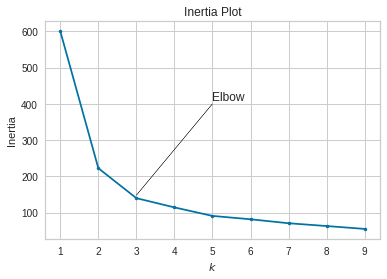

In [7]:
# Plot inertia by varying number of clusters
clusters = np.arange(1,10)
inertia = []
for c in clusters:
    kmeans = KMeans(n_clusters = c, random_state=1)
    kmeans.fit(X, y)
    inertia.append(kmeans.inertia_)
plt.plot(clusters, inertia, marker= '.')
plt.arrow(5, 400, -2, -252)
plt.text(5, 410, "Elbow", fontdict={'size': 12})
plt.title('Inertia Plot')
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()

From the above plot we can see, the inertia drops very quickly as we increase $k$ up to 3, but then it decreases much more slowly as we keep increasing $k$. This curve has roughly the shape of an arm, and there is an **“elbow”** at $k = 3$. So, if we did not know better, $3$ would be a good choice.

##Silhouette score



This technique for choosing the best value for the number of clusters is rather coarse. A **more precise approach** but also more computationally expensive is to use the **silhouette score**, which is the mean silhouette coefficient over all the instances. 

An instance’s silhouette coefficient is given by $$Sil(x_1) = \frac{(b – a)}{max(a, b)}$$ where, 

$a$ is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance), and 

$b$ is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes $b$, excluding the instance’s own cluster) as shown in the figure below. 

<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/Silhouette_coefficient.png" width= 500 px/>
</center>

The silhouette coefficient can vary between $–1$ and $+1$ as follows: 

* close to $+1$ means that the instance is well inside its own cluster and far from other clusters, 
* close to $0$ means that it is close to a cluster boundary, and  
* close to $–1$ means that the instance may have been assigned to the wrong cluster. 

To compute the silhouette score, we can use Scikit-Learn’s silhouette_score() function, giving it all the instances in the dataset and the labels they were assigned.


**Exercise 7 : Plot Silhouette score plot**

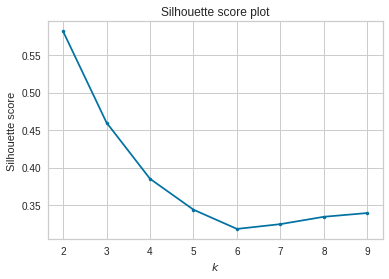

In [8]:
# Plot Silhouette score plot

clusters = np.arange(2,10)
sil_score = []
for c in clusters:
    kmeans = KMeans(n_clusters = c, random_state=1)
    kmeans.fit(X, y)
    sil_score.append(silhouette_score(X, kmeans.labels_))
plt.plot(clusters, sil_score, marker= '.')
plt.title('Silhouette score plot')
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.show()

As we can see, the above visualization is much richer than the previous one: although it shows that $k = 2$ is a good choice, it also underlines the fact that $k = 3$ is quite good as well and much better than $k = 4$ or $5$. This was not visible when comparing inertias. 



### DBSCAN (Density-based spatial clustering of applications with noise)

This algorithm defines clusters as continuous regions of high density. Here is how it works:

* For each instance, the algorithm counts how many instances are located within a small distance $ε$ (epsilon) from it. This region is called the instance’s $ε$-neighborhood.

* If an instance has at least `min_samples` instances in its $ε$-neighborhood (including itself), then it is considered a core instance. In other words, core instances are those that are located in dense regions.

* All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.

* Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. 

**Exercise 8 : Visualize moon's dataset with n_samples=1000 and noise=0.07**

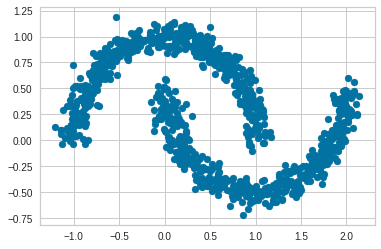

In [9]:
# Visualize data
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=0.07, random_state=1)
plt.scatter(X_moons[:,0], X_moons[:,1], cmap= "autumn")

# y_moons is for labels

**Exercise 9 : Perform k-mean clustering on the above moon's dataset**

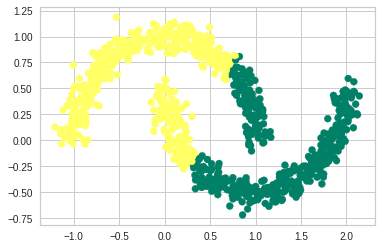

In [10]:
#perform k-mean clusering

kmeans = KMeans(n_clusters=2, random_state=1)
y_predict = kmeans.fit_predict(X_moons)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_predict, cmap = 'summer')
plt.show()

k-mean clustering method fails here.

**Exercise 9 : Perform  DBSCAN on data**

The labels of all the instances can be access via the `labels_` instance variable.

In [11]:
# Perform DBSCAN on data
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X_moons)
print("Unique clusters in data: ", np.unique(dbscan.labels_))

Unique clusters in data:  [-1  0  1]


Notice that some instances have a cluster index equal to $–1$, which means that they are considered as **anomalies** by the algorithm. 

**Exercise 10: Visualize data with DBSCAN labels and calculate silhouette_score**

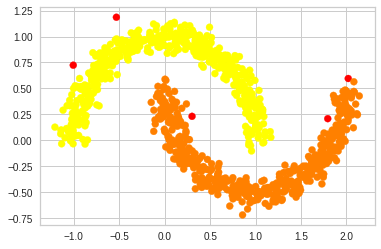

In [12]:
# Visualize data with DBSCAN labels
plt.scatter(X_moons[:,0], X_moons[:,1], c = dbscan.labels_, cmap= "autumn")

From the above plot, as we can see, it identified quite a lot of anomalies, plus two different clusters, which looks perfect. 

In [13]:
#print silhouette_score of above DBSCAN clustering
silhouette_score(X_moons,dbscan.labels_)

0.2620071776417522

**Exercise 11: Print the number of core instances,their indices and position**

The indices of the core instances are available in the `core_sample_indices_` instance variable, and the core instances themselves are available in the `components_` instance variable.

In [14]:
# Number of core instances their indices and position
num_of_core_instns = len(dbscan.core_sample_indices_)
print("Number of core instances: ", num_of_core_instns)

core_instns_indices = dbscan.core_sample_indices_
print("First 10 core instances indices: ", core_instns_indices[0:10])

core_instns = dbscan.components_
print("First 10 core instances: \n", core_instns[0:10])

Number of core instances:  973
First 10 core instances indices:  [ 0  1  2  3  4  5  6  7  9 10]
First 10 core instances: 
 [[ 0.09265036  0.37509504]
 [ 1.40558216 -0.51417142]
 [-0.88575515  0.18824291]
 [-0.68876666  0.80668479]
 [ 0.0316318   1.10179665]
 [ 1.84355084  0.09926668]
 [-0.01888625  0.98712515]
 [ 1.46879301 -0.3899634 ]
 [ 0.99819725  0.31113722]
 [-1.04276161  0.33324239]]


**Exercise 12: Perform DBSCAN on data by varying eps and min_samples and calculate silhouette score for each case**

In [15]:
#Perform DBSCAN on data
dbscan = DBSCAN(eps=0.05,min_samples=5)
dbscan.fit(X_moons)
print("Unique clusters in data: ", np.unique(dbscan.labels_))
print("silhoutte score=",silhouette_score(X_moons,dbscan.labels_))

Unique clusters in data:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32]
silhoutte score= -0.010282364957800598
